In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor as cat

import warnings
warnings.filterwarnings('ignore')

## Custom Functions

In [2]:
def data_viz(df, columns, target=None, plot_type='bar'):
    col_len = len(columns)
#     subplots_in_a_row = 0
    if plot_type == 'hist':
        subplots_in_a_row = 4
    else:
        subplots_in_a_row = 2
    number_of_rows, remainder = divmod(col_len, subplots_in_a_row)
    if remainder != 0:
        number_of_rows += 1
    fig, axes = plt.subplots(number_of_rows, subplots_in_a_row, figsize=(22, 6*number_of_rows))
    
    #Bivariate Analysis
    if plot_type == 'scatter':
        for col, subplot in zip(columns, axes.flatten()):
            sns.scatterplot(x=col, y=target, data=df, ax=subplot)
    elif plot_type == 'cross_tab':
        for col, subplot in zip(columns, axes.flatten()):
            ct = pd.crosstab(df[col], df[target])
            ct.plot.bar(ax=subplot)
            
    #Univariate Analysis
    elif plot_type == 'hist':
        for col, subplot in zip(columns, axes.flatten()):
            sns.distplot(df[col], ax=subplot)
    elif plot_type == 'box':
        for col, subplot in zip(columns, axes.flatten()):
            sns.boxplot(df[col], ax=subplot)
    else: # for bar and unrecognized type
        for col, subplot in zip(columns, axes.flatten()):
            sns.countplot(df[col], ax=subplot)

## Basic Analysis

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [4]:
train = train_df
test = test_df
target = 'Purchase'

train['is_train'] = 1
test['is_train'] = 0
test[target] = 0
full = train.append(test)

In [5]:
full.shape[0]

783667

In [6]:
full.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,is_train
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,1
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,1
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,1
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,1
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,1


In [7]:
full.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,is_train
count,7.836670e+05,783667.000000,783667.000000,783667.000000,537685.000000,237858.000000,783667.000000,783667.000000
mean,1.003029e+06,8.079300,0.409777,5.366196,9.844506,12.668605,6502.523064,0.701915
std,1.727267e+03,6.522206,0.491793,3.878160,5.089093,4.125510,5972.146799,0.457417
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000
25%,1.001519e+06,2.000000,0.000000,1.000000,5.000000,9.000000,0.000000,0.000000
50%,1.003075e+06,7.000000,0.000000,5.000000,9.000000,14.000000,6062.000000,1.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,9927.000000,1.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000,1.000000


In [8]:
full.isna().mean()*100# (full.isna().sum()/full.shape[0])*100

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.388587
Product_Category_3            69.648078
Purchase                       0.000000
is_train                       0.000000
dtype: float64

## EDA

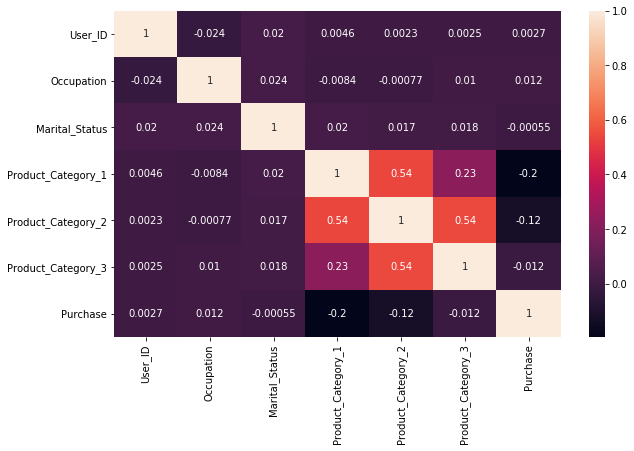

In [9]:
plt.subplots(figsize=(10,6))
sns.heatmap(full.drop(['is_train'], axis=1).corr(), annot=True)

In [10]:
numeric_columns = full.select_dtypes(exclude=['object']).columns.tolist()
numeric_columns.remove(target)
numeric_columns.remove('User_ID')
numeric_columns.remove('Occupation')
numeric_columns.remove('Marital_Status')
numeric_columns.remove('is_train')

categoric_columns = full.select_dtypes(include=['object']).columns.tolist()
categoric_columns.remove('Product_ID')
categoric_columns.append('Occupation')
categoric_columns.append('Marital_Status')

print(len(numeric_columns))
print(len(categoric_columns))

3
6


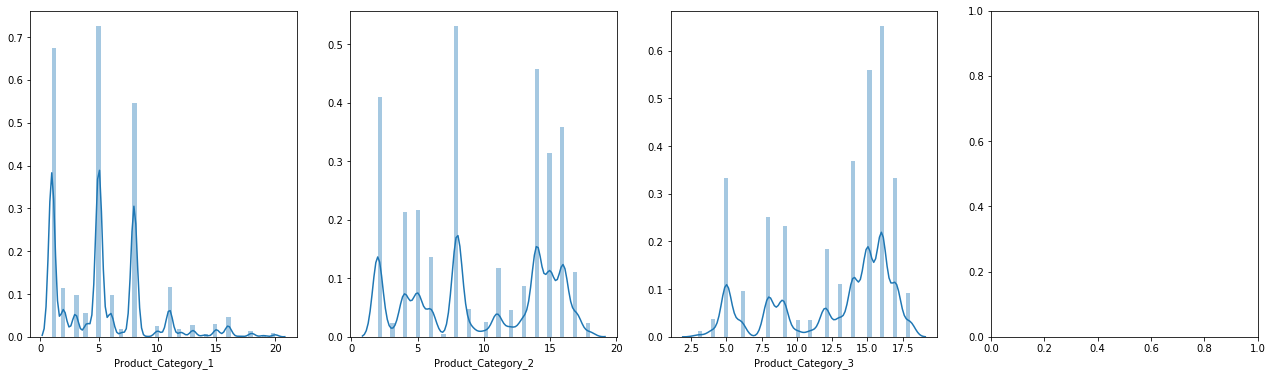

In [11]:
data_viz(full, numeric_columns, plot_type='hist')

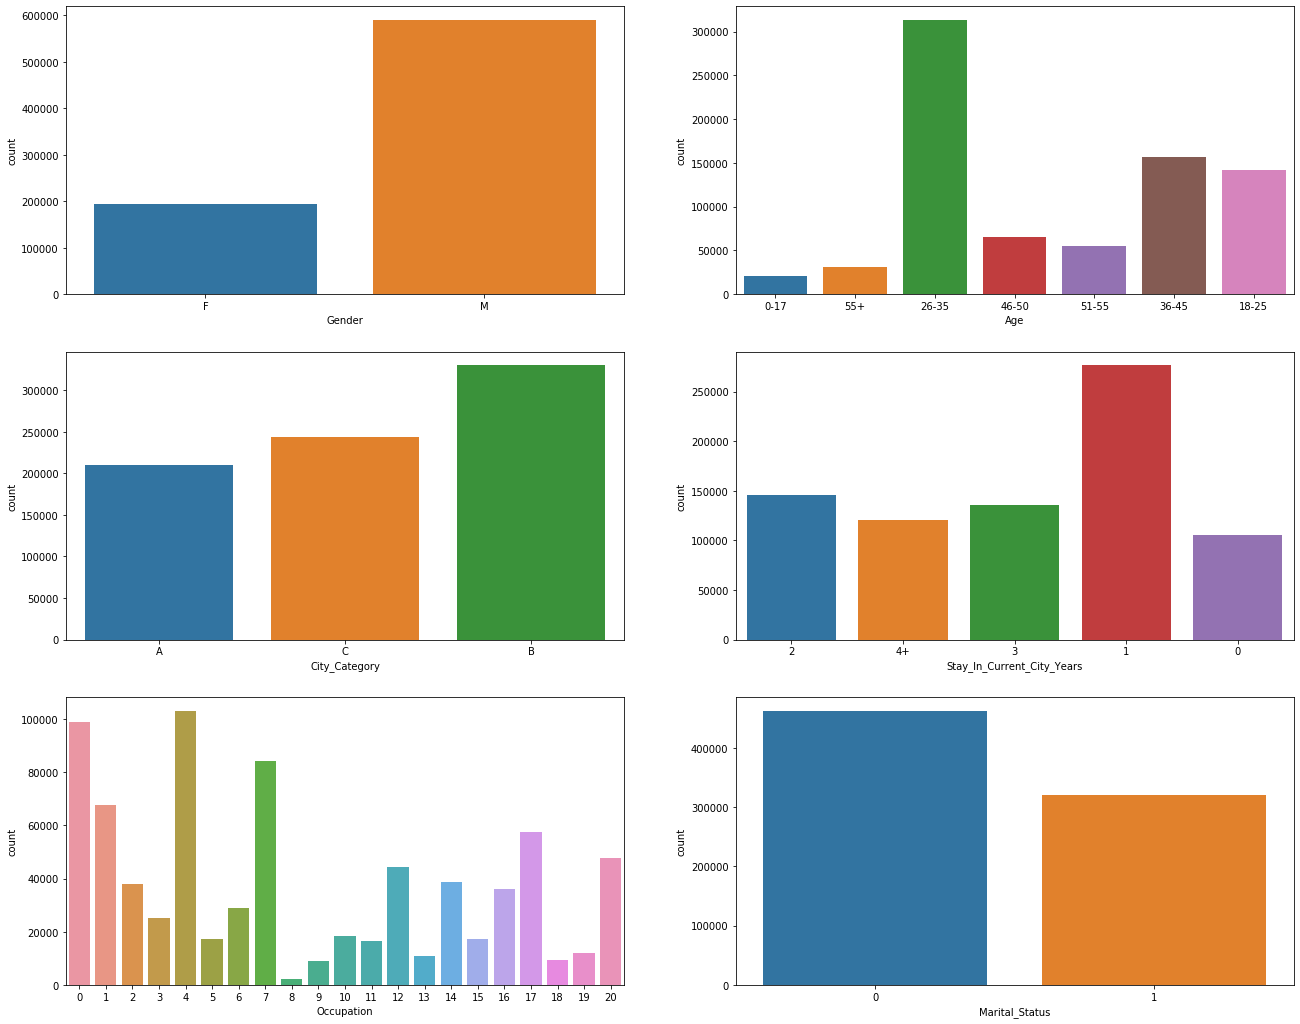

In [12]:
data_viz(full, categoric_columns, plot_type='bar')

In [49]:
#data_viz(full, numeric_columns, target=target,plot_type='scatter')

In [14]:
# comparable_columns = ['City_Category']
# data_viz(full, comparable_columns,target=target, plot_type='cross_tab')
# pd.crosstab(full['City_Category'], full[target])

## Data Cleaning

In [15]:
#Outlier Handling is not required here.
#Note: combined missing % is 100% for pc2 and pc3
both_null = full[(full['Product_Category_2'].isnull()) & (full['Product_Category_3'].isnull())]
both_null[['Product_Category_2','Product_Category_3']].isnull().sum()/full.shape[0]

Product_Category_2    0.313886
Product_Category_3    0.313886
dtype: float64

In [16]:
pc2_null_not_3 = full[(full['Product_Category_2'].isnull()) & (full['Product_Category_3'].notna())]
pc2_null_not_3.shape

(0, 13)

In [17]:
pc2_null = full[full['Product_Category_2'].isnull()]
pc3_null = full[full['Product_Category_3'].isnull()]

In [18]:
pc2_null.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,is_train
count,2.459820e+05,245982.000000,245982.000000,245982.000000,0.0,0.0,245982.000000,245982.000000
mean,1.003020e+06,7.976214,0.415986,7.831528,NaN,NaN,5307.425869,0.705897
std,1.718278e+03,6.559373,0.492892,3.925504,NaN,NaN,4883.580083,0.455639
min,1.000001e+06,0.000000,0.000000,1.000000,NaN,NaN,0.000000,0.000000
25%,1.001524e+06,2.000000,0.000000,5.000000,NaN,NaN,0.000000,0.000000
50%,1.003056e+06,7.000000,0.000000,8.000000,NaN,NaN,5397.000000,1.000000
75%,1.004459e+06,14.000000,1.000000,8.000000,NaN,NaN,8005.000000,1.000000
max,1.006040e+06,20.000000,1.000000,20.000000,NaN,NaN,23959.000000,1.000000


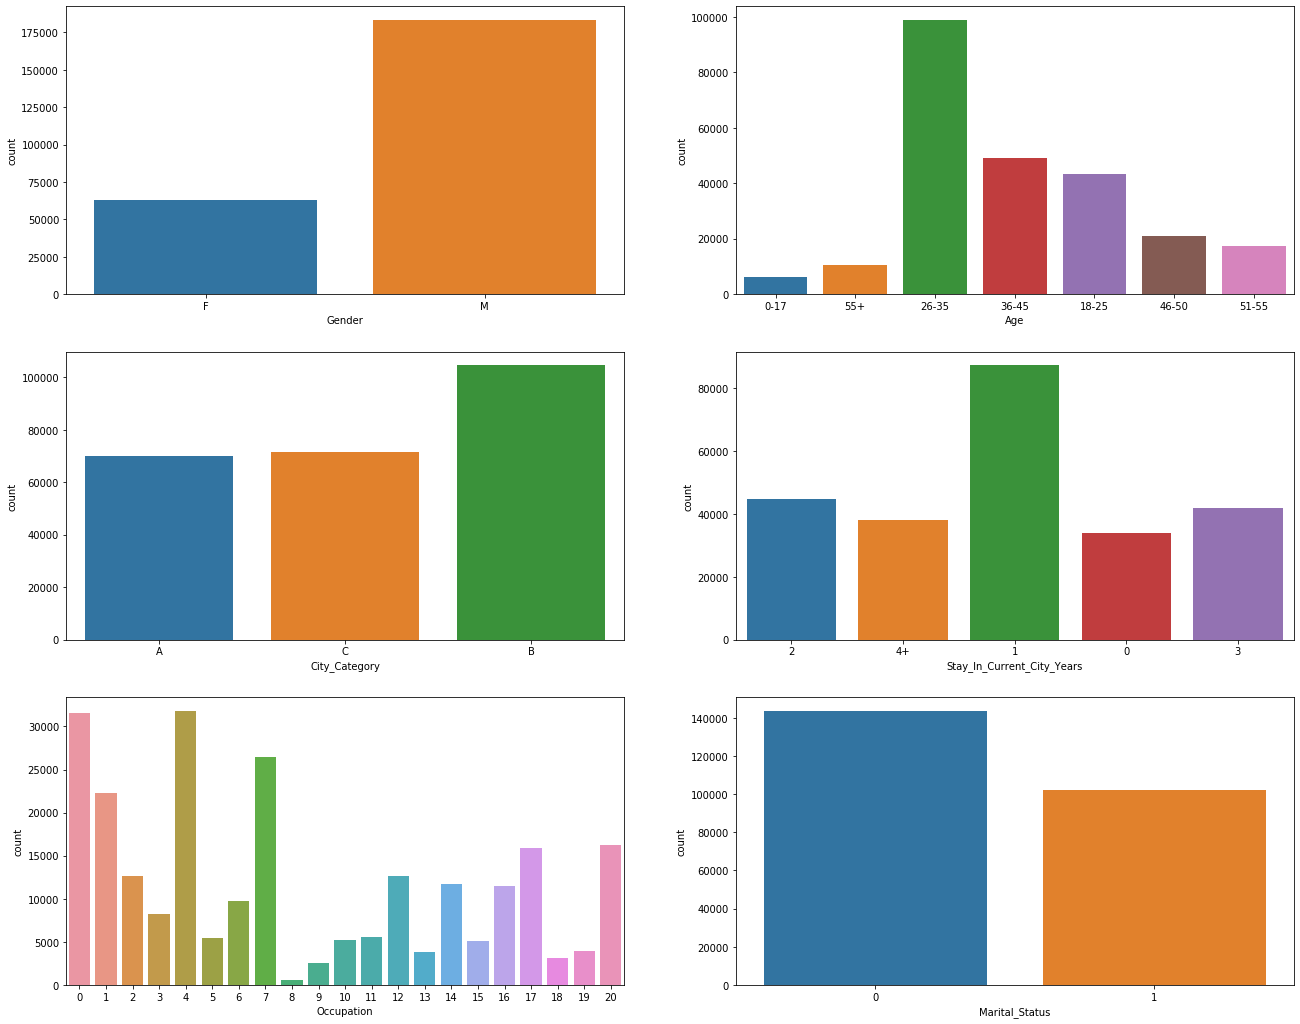

In [19]:
data_viz(pc2_null, categoric_columns, plot_type='bar')

In [20]:
pc2_null.nunique().head()

User_ID       5881
Product_ID    1860
Gender           2
Age              7
Occupation      21
dtype: int64

In [21]:
pc2_null_products = pc2_null['Product_ID'].tolist()
pc3_null_products = pc3_null['Product_ID'].tolist()

In [22]:
temp2 = full[(~full['Product_Category_2'].isnull())&(full['Product_ID'].isin(pc2_null_products))]
temp3 = full[(~full['Product_Category_3'].isnull())&(full['Product_ID'].isin(pc3_null_products))]

In [23]:
temp3.shape

(0, 13)

In [24]:
# full['Product_prefix'] = full['Product_ID'].apply(lambda x: x[0:3])
# full['Product_suffix'] = full['Product_ID'].apply(lambda x: x[3:])

In [25]:
full.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,is_train
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,1
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,1


In [26]:
full['Stay_In_Current_City_Years'].value_counts()

1     276425
2     145427
3     135428
4+    120671
0     105716
Name: Stay_In_Current_City_Years, dtype: int64

In [27]:
full['Total_Sales_By_Gender'] =  full.groupby('Gender')['Purchase'].transform('sum')
full['Total_Sales_By_Age'] =  full.groupby('Age')['Purchase'].transform('sum')
full['Total_Sales_By_Occupation'] =  full.groupby('Occupation')['Purchase'].transform('sum')
full['Total_Sales_By_City'] =  full.groupby('City_Category')['Purchase'].transform('sum')
full['Total_Sales_By_Stay'] =  full.groupby('Stay_In_Current_City_Years')['Purchase'].transform('sum')
full['Total_Sales_By_marital'] =  full.groupby('Marital_Status')['Purchase'].transform('sum')
full['Total_Sales_By_pc1'] =  full.groupby(['Product_Category_1'])['Purchase'].transform('sum')

In [28]:
full['frequency_By_Gender'] =  full.groupby('Gender')['Purchase'].transform('count')
full['frequency_By_Age'] =  full.groupby('Age')['Purchase'].transform('count')
full['frequency_By_Occupation'] =  full.groupby('Occupation')['Purchase'].transform('count')
full['frequency_By_City'] =  full.groupby('City_Category')['Purchase'].transform('count')
full['frequency_By_Stay'] =  full.groupby('Stay_In_Current_City_Years')['Purchase'].transform('count')
full['frequency_By_marital'] =  full.groupby('Marital_Status')['Purchase'].transform('count')
full['frequency_By_pc1'] =  full.groupby(['Product_Category_1'])['Purchase'].transform('count')


full['max_By_Gender'] =  full.groupby('Gender')['Purchase'].transform('count')
full['max_By_Age'] =  full.groupby('Age')['Purchase'].transform('count')
full['max_By_Occupation'] =  full.groupby('Occupation')['Purchase'].transform('count')
full['max_By_City'] =  full.groupby('City_Category')['Purchase'].transform('count')
full['max_By_Stay'] =  full.groupby('Stay_In_Current_City_Years')['Purchase'].transform('count')
full['max_By_marital'] =  full.groupby('Marital_Status')['Purchase'].transform('count')
full['max_By_pc1'] =  full.groupby(['Product_Category_1'])['Purchase'].transform('count')


full['min_By_Gender'] =  full.groupby('Gender')['Purchase'].transform('min')
full['min_By_Age'] =  full.groupby('Age')['Purchase'].transform('min')
full['min_By_Occupation'] =  full.groupby('Occupation')['Purchase'].transform('min')
full['min_By_City'] =  full.groupby('City_Category')['Purchase'].transform('min')
full['min_By_Stay'] =  full.groupby('Stay_In_Current_City_Years')['Purchase'].transform('min')
full['min_By_marital'] =  full.groupby('Marital_Status')['Purchase'].transform('min')
full['min_By_pc1'] =  full.groupby(['Product_Category_1'])['Purchase'].transform('min')


full['std_By_Gender'] =  full.groupby('Gender')['Purchase'].transform('std')
full['std_By_Age'] =  full.groupby('Age')['Purchase'].transform('std')
full['std_By_Occupation'] =  full.groupby('Occupation')['Purchase'].transform('std')
full['std_By_City'] =  full.groupby('City_Category')['Purchase'].transform('std')
full['std_By_Stay'] =  full.groupby('Stay_In_Current_City_Years')['Purchase'].transform('std')
full['std_By_marital'] =  full.groupby('Marital_Status')['Purchase'].transform('std')
full['std_By_pc1'] =  full.groupby(['Product_Category_1'])['Purchase'].transform('std')

In [29]:
full['Total_By_marital_Gender'] =  full.groupby(['Marital_Status', 'Gender'])['Purchase'].transform('sum')
full['frequency_By_marital_Gender'] =  full.groupby(['Marital_Status', 'Gender'])['Purchase'].transform('count')
full['min_By_marital_Gender'] =  full.groupby(['Marital_Status', 'Gender'])['Purchase'].transform('min')
full['max_By_marital_Gender'] =  full.groupby(['Marital_Status', 'Gender'])['Purchase'].transform('max')
full['std_By_marital_Gender'] =  full.groupby(['Marital_Status', 'Gender'])['Purchase'].transform('std')

full['Total_By_city_occp'] =  full.groupby(['City_Category', 'Occupation'])['Purchase'].transform('sum')
full['frequency_By_city_occp'] =  full.groupby(['City_Category', 'Occupation'])['Purchase'].transform('count')
full['min_By_city_occp'] =  full.groupby(['City_Category', 'Occupation'])['Purchase'].transform('min')
full['max_By_city_occp'] =  full.groupby(['City_Category', 'Occupation'])['Purchase'].transform('max')
full['std_By_city_occp'] =  full.groupby(['City_Category', 'Occupation'])['Purchase'].transform('std')



In [30]:
full['Product_Category_2'].fillna(-1, inplace=True)
full['Product_Category_3'].fillna(-1, inplace=True)

In [31]:
full['total_By_pc2'] =  full.groupby(['Product_Category_2'])['Purchase'].transform('sum')
full['frequency_By_pc2'] =  full.groupby(['Product_Category_2'])['Purchase'].transform('count')
full['min_By_pc2'] =  full.groupby(['Product_Category_2'])['Purchase'].transform('min')
full['max_By_pc2'] =  full.groupby(['Product_Category_2'])['Purchase'].transform('max')
full['std_By_pc2'] =  full.groupby(['Product_Category_2'])['Purchase'].transform('std')

full['total_By_pc3'] =  full.groupby(['Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_pc3'] =  full.groupby(['Product_Category_3'])['Purchase'].transform('count')
full['min_By_pc3'] =  full.groupby(['Product_Category_3'])['Purchase'].transform('min')
full['max_By_pc3'] =  full.groupby(['Product_Category_3'])['Purchase'].transform('max')
full['std_By_pc3'] =  full.groupby(['Product_Category_3'])['Purchase'].transform('std')

In [32]:
full['Total_By_stay_prod'] =  full.groupby(['Stay_In_Current_City_Years', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_stay_prod'] =  full.groupby(['Stay_In_Current_City_Years', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('count')
full['min_By_stay_prod'] =  full.groupby(['Stay_In_Current_City_Years', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('min')
full['max_By_stay_prod'] =  full.groupby(['Stay_In_Current_City_Years', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('max')
full['std_By_stay_prod'] =  full.groupby(['Stay_In_Current_City_Years', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('std')


full['Total_By_marital_prod'] =  full.groupby(['Marital_Status', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_marital_prod'] =  full.groupby(['Marital_Status', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('count')
full['min_By_marital_prod'] =  full.groupby(['Marital_Status', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('min')
full['max_By_marital_prod'] =  full.groupby(['Marital_Status', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('max')
full['std_By_marital_prod'] =  full.groupby(['Marital_Status', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('std')


full['Total_By_age_prod'] =  full.groupby(['Age', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_age_prod'] =  full.groupby(['Age', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('count')
full['min_By_age_prod'] =  full.groupby(['Age', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('min')
full['max_By_age_prod'] =  full.groupby(['Age', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('max')
full['std_By_age_prod'] =  full.groupby(['Age', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('std')


full['Total_By_Gender_prod'] =  full.groupby(['Gender', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_Gender_prod'] =  full.groupby(['Gender', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('count')
full['min_By_Gender_prod'] =  full.groupby(['Gender', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('min')
full['max_By_Gender_prod'] =  full.groupby(['Gender', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('max')
full['std_By_Gender_prod'] =  full.groupby(['Gender', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('std')




full['Total_By_city_prod'] =  full.groupby(['City_Category', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_city_prod'] =  full.groupby(['City_Category', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('count')
full['min_By_city_prod'] =  full.groupby(['City_Category', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('min')
full['max_By_city_prod'] =  full.groupby(['City_Category', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('max')
full['std_By_city_prod'] =  full.groupby(['City_Category', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('std')


full['Total_By_occp_prod'] =  full.groupby(['Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_occp_prod'] =  full.groupby(['Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('count')
full['min_By_occp_prod'] =  full.groupby(['Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('min')
full['max_By_occp_prod'] =  full.groupby(['Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('max')
full['std_By_occp_prod'] =  full.groupby(['Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('std')


full['Total_By_city_occp_prod'] =  full.groupby(['City_Category','Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('sum')
full['frequency_By_city_occp_prod'] =  full.groupby(['City_Category','Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('count')
full['min_By_city_occp_prod'] =  full.groupby(['City_Category','Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('min')
full['max_By_city_occp_prod'] =  full.groupby(['City_Category','Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('max')
full['std_By_city_occp_prod'] =  full.groupby(['City_Category','Occupation', 'Product_Category_1','Product_Category_2', 'Product_Category_3'])['Purchase'].transform('std')

In [33]:
full['user_count'] = full.groupby('User_ID')['User_ID'].transform('count')
full['product_count'] = full.groupby('Product_ID')['Product_ID'].transform('count')

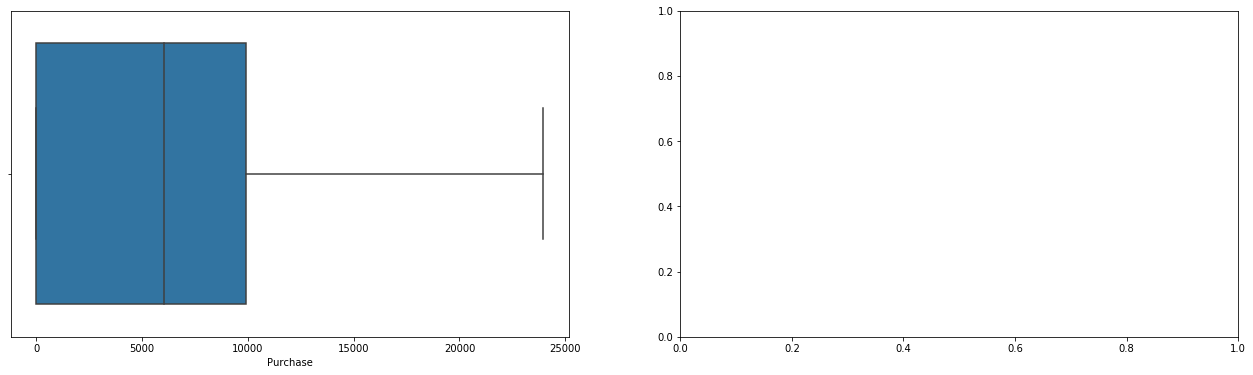

In [34]:
data_viz(full, ['Purchase'], plot_type='box')

In [35]:
# plt.subplots(figsize=(22,6))
# sns.heatmap(full.corr(), annot=True)

In [36]:
full.dtypes

User_ID                    int64
Product_ID                object
Gender                    object
Age                       object
Occupation                 int64
                          ...   
min_By_city_occp_prod      int64
max_By_city_occp_prod      int64
std_By_city_occp_prod    float64
user_count                 int64
product_count              int64
Length: 105, dtype: object

In [37]:
label_encoder = LabelEncoder()
full['Gender'] = label_encoder.fit_transform(full['Gender'])
full['Age'] = label_encoder.fit_transform(full['Age'])
full['City_Category'] = label_encoder.fit_transform(full['City_Category'])
full['Stay_In_Current_City_Years'] = label_encoder.fit_transform(full['Stay_In_Current_City_Years'])

In [38]:
test_product_Id = full[full['is_train']==0]['Product_ID']
full = pd.get_dummies(full.drop('Product_ID', axis=1))

In [39]:
full.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,...,min_By_occp_prod,max_By_occp_prod,std_By_occp_prod,Total_By_city_occp_prod,frequency_By_city_occp_prod,min_By_city_occp_prod,max_By_city_occp_prod,std_By_city_occp_prod,user_count,product_count
0,1000001,0,0,10,0,2,0,3,-1.0,-1.0,...,0,13456,4977.328110,8370,2,0,8370,5918.483759,47,344
1,1000001,0,0,10,0,2,0,1,6.0,14.0,...,0,19696,8210.962210,82393,10,0,19696,7693.489471,47,845
2,1000001,0,0,10,0,2,0,12,-1.0,-1.0,...,0,1772,656.085916,21416,21,0,1772,614.017884,47,150
3,1000001,0,0,10,0,2,0,12,14.0,-1.0,...,0,1776,677.860438,14036,15,0,1745,718.817031,47,496
4,1000002,1,6,16,2,4,0,8,-1.0,-1.0,...,0,10082,3795.939202,7763803,1390,0,10082,3803.697047,107,283


## Basic Model Building

In [40]:
train = full[full['is_train'] == 1]
test = full[full['is_train'] == 0]
test.drop(['Purchase', 'is_train'],axis=1, inplace=True)

y= train['Purchase']
train.drop(['Purchase', 'is_train'],axis=1, inplace=True)

In [41]:
pd.set_option('display.max_columns', 500)
train.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Total_Sales_By_Gender,Total_Sales_By_Age,Total_Sales_By_Occupation,Total_Sales_By_City,Total_Sales_By_Stay,Total_Sales_By_marital,Total_Sales_By_pc1,frequency_By_Gender,frequency_By_Age,frequency_By_Occupation,frequency_By_City,frequency_By_Stay,frequency_By_marital,frequency_By_pc1,max_By_Gender,max_By_Age,max_By_Occupation,max_By_City,max_By_Stay,max_By_marital,max_By_pc1,min_By_Gender,min_By_Age,min_By_Occupation,min_By_City,min_By_Stay,min_By_marital,min_By_pc1,std_By_Gender,std_By_Age,std_By_Occupation,std_By_City,std_By_Stay,std_By_marital,std_By_pc1,Total_By_marital_Gender,frequency_By_marital_Gender,min_By_marital_Gender,max_By_marital_Gender,std_By_marital_Gender,Total_By_city_occp,frequency_By_city_occp,min_By_city_occp,max_By_city_occp,std_By_city_occp,total_By_pc2,frequency_By_pc2,min_By_pc2,max_By_pc2,std_By_pc2,total_By_pc3,frequency_By_pc3,min_By_pc3,max_By_pc3,std_By_pc3,Total_By_stay_prod,frequency_By_stay_prod,min_By_stay_prod,max_By_stay_prod,std_By_stay_prod,Total_By_marital_prod,frequency_By_marital_prod,min_By_marital_prod,max_By_marital_prod,std_By_marital_prod,Total_By_age_prod,frequency_By_age_prod,min_By_age_prod,max_By_age_prod,std_By_age_prod,Total_By_Gender_prod,frequency_By_Gender_prod,min_By_Gender_prod,max_By_Gender_prod,std_By_Gender_prod,Total_By_city_prod,frequency_By_city_prod,min_By_city_prod,max_By_city_prod,std_By_city_prod,Total_By_occp_prod,frequency_By_occp_prod,min_By_occp_prod,max_By_occp_prod,std_By_occp_prod,Total_By_city_occp_prod,frequency_By_city_occp_prod,min_By_city_occp_prod,max_By_city_occp_prod,std_By_city_occp_prod,user_count,product_count
0,1000001,0,0,10,0,2,0,3,-1.0,-1.0,1186232642,134913183,115844465,1316471661,949173931,3008927447,204084713,193636,21334,18304,210244,145427,462538,28791,193636,21334,18304,210244,145427,462538,28791,0,0,0,0,0,0,0,5649.717330,5915.707904,5932.761412,5780.202935,6004.486812,5975.188924,5189.003849,684154127,112469,0,23955,5616.288129,19131586,3138,0,23847,5737.017174,1305531230,245982,0,23959,4883.580083,3150994343,545809,0,23961,5399.626264,583575,72,0,13702,5930.813820,1585875,206,0,13716,5821.592687,46473,10,0,13702,6170.581569,736217,88,0,13711,5795.139658,825790,106,0,13716,5800.504064,21826,9,0,13456,4977.328110,8370,2,0,8370,5918.483759,47,344
1,1000001,0,0,10,0,2,0,1,6.0,14.0,1186232642,134913183,115844465,1316471661,949173931,3008927447,1910013754,193636,21334,18304,210244,145427,462538,200699,193636,21334,18304,210244,145427,462538,200699,0,0,0,0,0,0,0,5649.717330,5915.707904,5932.761412,5780.202935,6004.486812,5975.188924,7200.280758,684154127,112469,0,23955,5616.288129,19131586,3138,0,23847,5737.017174,189417477,23575,0,19708,6841.088506,185249212,26283,0,20689,6174.339035,4178641,400,0,19696,7850.217664,13271648,1291,0,19708,7839.605758,501746,47,0,19696,8083.038766,5028847,451,0,19703,7686.577700,6202623,607,0,19698,7798.986425,415871,41,0,19696,8210.962210,82393,10,0,19696,7693.489471,47,845
2,1000001,0,0,10,0,2,0,12,-1.0,-1.0,1186232642,134913183,115844465,1316471661,949173931,3008927447,5331844,193636,21334,18304,210244,145427,462538,5610,193636,21334,18304,210244,145427,462538,5610,0,0,0,0,0,0,0,5649.717330,5915.707904,5932.761412,5780.202935,6004.486812,5975.188924,687.827207,684154127,112469,0,23955,5616.288129,19131586,3138,0,23847,5737.017174,1305531230,245982,0,23959,4883.580083,3150994343,545809,0,23961,5399.626264,412653,445,0,1778,688.077393,1202112,1270,0,1778,683.951272,85440,83,0,1772,673.344274,954167,969,0,1778,700.566527,626588,659,0,1778,664.008536,72466,68,0,1772,656.085916,21416,21,0,1772,614.017884,47,150
3,1000001,0,0,10,0,2,0,12,14.0,-1.0,1186232642,134913183,115844465,1316471661,949173931,3008927447,5331844,193636,21334,18304,210244,145427,462538,5610,193636,21334,18304,210244,145427,462538,5610,0,0,0,0,0,0,0,5649.717330,5915.707904,5932.761412,5780.202935,60

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['User_ID'], axis=1), y)

In [43]:
# xgb_model = XGBRegressor(n_estimators=100,
#                          learning_rate=0.3,
#                          colsample_bytree = 0.7,
#                          colsample_bylevel = 0.7,
#                          random_state=0,
#                          max_depth=30,
#                          verbosity=0)
# xgb_model.fit(X_train, y_train, early_stopping_rounds=500,eval_metric=["rmse"], eval_set=[(X_val, y_val)])

In [44]:
# for col in X_train.drop(['Gender', 'Age'], axis=1).columns.tolist():
#     print(col)
#     xgb_model.fit(X_train[col], y_train, early_stopping_rounds=5,eval_metric=["rmse"], eval_set=[(X_val, y_val)])

In [45]:
lgb_model = lgb.LGBMRegressor(nestimators=1000, learning_rate=0.3, max_depth = 50, random_state=15)

In [46]:
lgb_model.fit(X_train, y_train)
y_test = lgb_model.predict(test.drop(['User_ID'], axis=1))

In [47]:
output = pd.DataFrame({'Purchase':y_test, 'User_ID':test['User_ID'], 'Product_ID':test_product_Id})

In [48]:
output.to_csv('submission.csv', index=False)